In [339]:
# ANALYSIS AND PLOTTING 

# LIBRARIES
import pylab
import json
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pylab as pylab
from scipy.stats import sem
import pandas as pd

In [340]:
# LOADING DATA 
# SUBJECT
subjs_data = open('../data/main_run_v1/main_run_1_80_subj_prolific_01_24_2021.json') 
subjs_data = json.load(subjs_data) 

# MODEL
mod_data = open('../model/notebooks/naïve_mod_parameter.txt')
mod_data = json.load(mod_data)

In [357]:
# EXTRACTING ID, STIMULI,RESPONSES, AND OTHER RELEVANT DATA FROM SUBJECTS
subjs = list(subjs_data.keys())

# BONI
subjs_structure_bonus = {}
subjs_selection_bonus = {}
subjs_total_bonus = {}
gender = {'male': 0, 'female': 0, 'other': 0}
age = []

# REORDERING SUBJS DATA
subjs_selection = {'independent': [], 'b->c': [], 'c->b': [], 'b<->c': [], 'b<->c_echo': []} # planet selected by subjs
subjs_beliefs = {'independent': [], 'b->c': [], 'c->b': [], 'b<->c': [], 'b<->c_echo': []}   # initial belief / fish shown to subjs
subjs_side = {'independent': [], 'b->c': [], 'c->b': [], 'b<->c': [], 'b<->c_echo': []}      # which side aligned with subjs belief
subjs_structure = {'independent': [], 'b->c': [], 'c->b': [], 'b<->c': [], 'b<->c_echo': []} # structure selected by subjects

# MODEL PREDICTIONS
mods_selection = {'independent': [], 'b->c': [], 'c->b': [], 'b<->c': [], 'b<->c_echo': []}  # predicted planet selection for subjs based on mod params
mods_structure = {}
count = 0
for subj in subjs:
    count +=1
    # RAW VARIABLES 
    subj_key = list(subjs_data[subj].keys())[0]
    subj_data = subjs_data[subj][subj_key]['participantData']
    cond_data = subjs_data[subj][subj_key]['conditionsData']
    prolific_id = subjs_data[subj][subj_key]['PID']['pid']
    age.append(int(subjs_data[subj][subj_key]['debriefData']['age']))
    gender[subjs_data[subj][subj_key]['debriefData']['gender']] += 1

    # NEW VARIABLES
    cond_order = []      # true condition order 
    subj_structure = []  # subject condition selections 
    cond_belief = []     # initial fish shown to subjs
    subj_selection = []  # planet selected by subjects 
    left_right = []      # whether left or right peer was in line or against subjs inisial belief (left: left against; right: right against)
    
    for cond in cond_data:
        cond_belief.append(cond['targetBelief'])
        cond_order.append(cond['condition'])
        left_right.append(cond['left_right'])
        
    for selection in subj_data:
        subj_selection.append(selection['selection'])
        subj_structure.append(selection['structure']['causalStructure'])
            
    # COMPUTE STRUCTURE BONUS
    structure_bonus = 0
    for cond,structure in zip(cond_order, subj_structure):
        if cond == structure:
            structure_bonus += 0.25
    subjs_structure_bonus[prolific_id] = structure_bonus
    
    # COMPUTE SELECTION BONUS
    selection_bonus = 0
    for belief,selection in zip(cond_belief,subj_selection):
        if belief == 'deepskyblue' and selection['planet'] == 'blue':
            selection_bonus += 0.25
        elif belief == 'red' and selection['planet'] == 'red':
            selection_bonus += 0.25    
    subjs_selection_bonus[prolific_id] = selection_bonus
    
    # COMPUTING TOTAL BONUS
    subjs_total_bonus[prolific_id] = structure_bonus + selection_bonus
    
    for cond,selection,belief,structure in zip(cond_order,subj_selection,cond_belief,subj_structure):
        # RECODING CONDITION NAMES
        if cond == 'lr':
            cond = 'b->c'
        elif cond == 'rl':
            cond = 'c->b'
        elif cond == 'both':
            cond = 'b<->c'
        elif cond == 'bothExcite':
            cond = 'b<->c_echo'
        
        # RECODING STRUCTURE NAMES
        if structure == 'lr':
            structure = 'b->c'
        elif structure == 'rl':
            structure = 'c->b'
        elif structure == 'both':
            structure = 'b<->c'
        elif structure == 'bothExcite':
            structure = 'b<->c_echo'
        
   
        # RECODING RESPONSE SCALE FOR RED PLANET TO MEET 4-6 PART OF SCALE     
        if selection['planet'] == 'red':
            response = selection['confidence'] + 3
            
        # FLIPPING BLUE PLANET SELECTIONS FROM 3-1 TO 1-3
        elif selection['planet'] == 'blue':
            response = selection['confidence']
            if response == 3:
                response= 1
            elif response == 2:
                response = 2
            elif response == 1:
                response = 3

        # NOW THAT WE HAVE 1-6 SCALE, NEED TO FLIP SELECTIONS FOR INITIAL BELIEF BEING BLUE  
        if belief == 'deepskyblue':
            if response == 1:
                response = 6
            elif response == 2:
                response = 5
            elif response == 3:
                response = 4
            elif response == 4:
                response = 3
            elif response == 5:
                response = 2
            elif response == 6:
                response = 1
        
        # FLIPPING CONDITION FOR SELECTION IF OPPOSING BELIEF WAS RIGHT VS LEFT  
        if cond == 'b->c' or cond == 'c->b':                    
            if left_right[0] == 'right':
                if cond == 'b->c':
                    cond = 'c->b'
                elif cond == 'c->b':
                    cond = 'b->c'
                # NEED TO FLIP SELECTED STRUCTURE AS WELL 
                if structure == 'b->c':
                    structure = 'c->b'
                elif structure == 'c->b':
                    structure = 'b->c'
                
        
        # APPENDING DATA
        subjs_selection[cond].append(response)
        subjs_beliefs[cond].append(belief)
        subjs_side[cond].append(left_right[0])
        subjs_structure[cond].append(structure)
        
        # RECODING COND TO MEET INDEPENDENT KEY IN MOD DATA
        cond_corrected = cond
        if cond == 'independent':
            cond_corrected = 'indep'
        
        # RECODING AND APPENDING MODEL SELECITONS 
        a = mod_data[cond_corrected][9]['0']['a'] 
        b = mod_data[cond_corrected][9]['0']['b']
        a_corrected = a
        b_corrected = b
        
        if belief == 'deepskyblue':
            a_corrected = b
            b_corrected = a
            
        if left_right[0] == 'right' and cond_corrected == 'b->c':
            cond = 'c->b'
            a_corrected = b
            b_corrected = a
        elif left_right[0] == 'right' and cond_corrected == 'c->b':
            cond = 'b->c'
            a_corrected = a
            b_corrected = b
        mods_selection[cond].append({'a': a_corrected, 'b': b_corrected})
        
    

# PRINTING OUT BONI IN FORMAT SUITABLE FOR COPY-PASTING TO PROLIFIC
for k in subjs_total_bonus:
    print(k,",",subjs_total_bonus[k])

print(np.mean(age))
print(np.std(age))
print(gender)
print(count)

5f58ba3ab3a4a40440cdd9ee , 2.5
600bc63e9b60d819b7ef33a1 , 2.25
5fa11b002616091abfbb37ab , 1.5
5fc563acb7319e0978abf273 , 2.0
5f51114394f9472e53bc5936 , 0.5
5f6da946688fd3223e3ba651 , 1.5
5ff619d384079f1372640915 , 2.0
5bf2ee250d0d960001575007 , 1.5
5cb37ab31ffb8d0016fb5196 , 2.0
5a65011f63394a0001556857 , 1.75
57c40141ccfe7800015dd044 , 1.75
5830290e9adab800018bbf04 , 1.5
58f368386eec530001c28cd5 , 1.25
5d049ac90e44360001a3ec4a , 1.5
599da21f872eec00019569ff , 1.5
5f6b5717aea0f00277f7125d , 1.75
5f441181bb3f780f570dc54c , 1.75
5eaf0cbc48b26f5e7d7c574f , 0.5
60037b8167c8e94503250c1e , 1.75
56b8ad1be1d0a2000c154093 , 1.75
5c9a2a8fa32382000162eba4 , 1.5
5d47fe3b29194200012bf92d , 1.75
5fba591179dc339e264745c2 , 1.0
5f89aa9fa1593c090da5b57b , 1.5
57027b6768c641000e0c894a , 1.5
5f4a33e6d0e4f9031cdc7428 , 1.25
5ad7df89c25ea000018849f1 , 1.5
5ead58cf86ea9b025ef6c153 , 1.0
5f3ae1d5f90ced1a9da43f2d , 1.5
5bc33a0bdf712a000177b62b , 2.0
5e944b1dc7296a01214955ee , 1.5
5b59e2dff5bc59000117440c , 2.

independent
b->c
c->b
b<->c
b<->c_echo
{'indep': [0.036231884057971016, 0.11594202898550725, 0.07246376811594203, 0.18115942028985507, 0.4057971014492754, 0.18840579710144928], 'b->c': [0.07446808510638298, 0.2978723404255319, 0.1276595744680851, 0.1276595744680851, 0.23404255319148937, 0.13829787234042554], 'c->b': [0.056818181818181816, 0.20454545454545456, 0.03409090909090909, 0.045454545454545456, 0.3522727272727273, 0.3068181818181818], 'b<->c': [0.03529411764705882, 0.1411764705882353, 0.08235294117647059, 0.27058823529411763, 0.3411764705882353, 0.12941176470588237]}


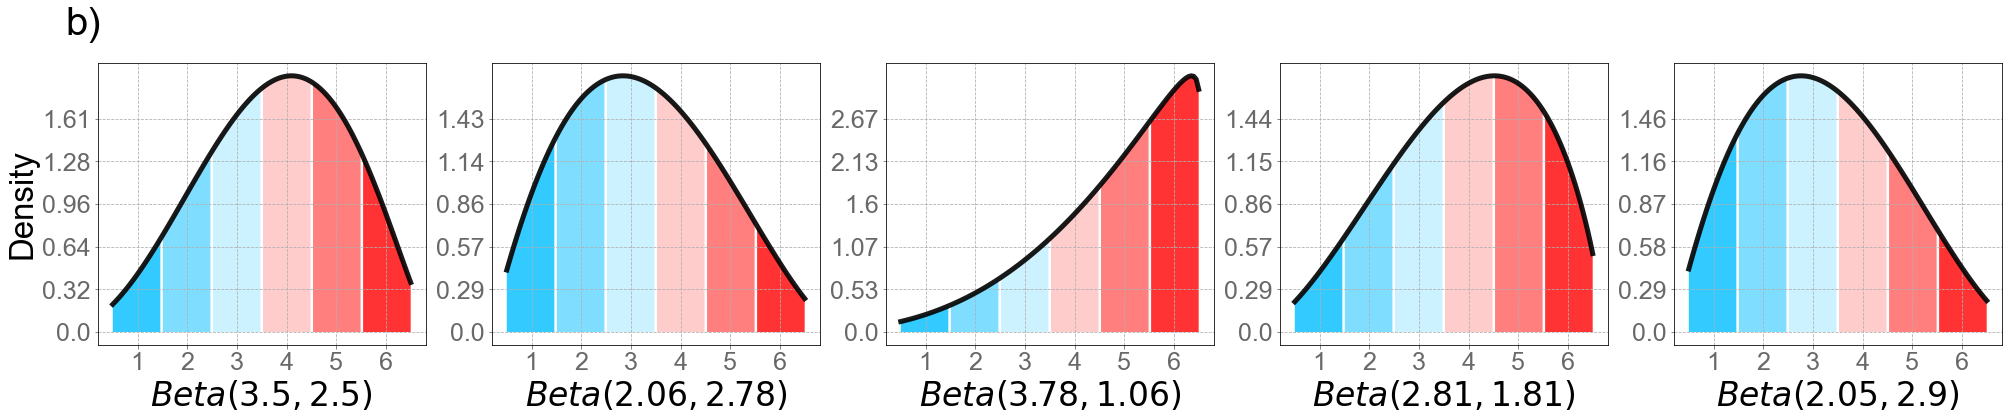

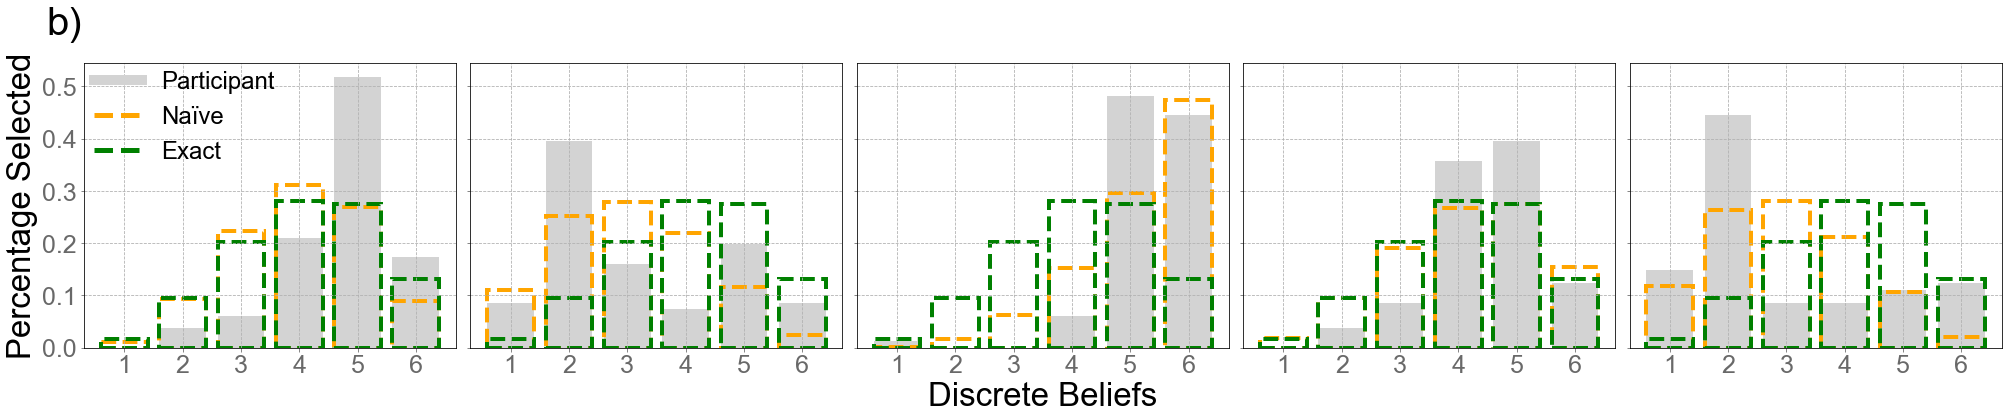

{'indep': [0.011915553219199293, 0.09413158103533886, 0.22418759311410685, 0.31078976862513574, 0.2689515783955603, 0.09002392561065897], 'b->c': [0.10993824941842623, 0.25194455763172313, 0.27831578418772956, 0.21926095031923554, 0.11654269634634307, 0.023997762096542474], 'c->b': [0.0012745535279745802, 0.016058349058828948, 0.06197193422729697, 0.15240624958529433, 0.2952909025934558, 0.47299801100714933], 'b<->c': [0.018201486917869342, 0.09440103105306426, 0.1913212681020697, 0.266429931569917, 0.27571939173887605, 0.15392689061820364], 'b<->c_echo': [0.11750600885171203, 0.26265857153519767, 0.2811188873537672, 0.2125128039593669, 0.10637695649724543, 0.019826771802710752]}


In [358]:
# ANALYSING PLANET SELECTION


# GENERIC BIN FUNCTION
def create_beta_bins(a, b, n_bins=6): 
    betacdf = beta(a,b).cdf 
    beta_bins = [] 
    for beta_bin in range(1,n_bins+1): 
        if beta_bin == 1: 
            beta_bins.append(betacdf(beta_bin/n_bins)) 
        else: 
            beta_bins.append(betacdf(beta_bin/n_bins)-betacdf((beta_bin-1)/n_bins))
    return beta_bins

# PLOTTING BETA DENSITY AND BINS FOR EACH COMBINATION OF MODEL PARAMETERS
# GLOBAL PLOT PARAMETERS 
plot_params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'35',
               'axes.labelsize':'33',
         'xtick.labelsize':'25',
          'font.family': 'Arial',
          'xtick.color':'dimgrey',
          'ytick.color':'dimgrey',
         'ytick.labelsize':'25'}
pylab.rcParams.update(plot_params)

# CONTINUOUS BETA 
def plot_beta(params, n_bins=6): 
    fig, axs = plt.subplots(1, 5, figsize=(28,6)) 
#     fig.delaxes(axs[2,1])
    ax_pos = {'indep': [0], 'b->c': [1],'c->b': [2], 'b<->c': [3],'b<->c_echo': [4]} 
    bins = ['1','2','3','4','5','6'] 
    bin_colors = ['deepskyblue','deepskyblue','deepskyblue','red','red','red']
    bin_alphas = [0.8,0.5,0.2,0.2,0.5,0.8]
    fig_labels = {'indep': 'a)', 'b->c': 'b)','c->b': 'c)', 'b<->c': 'd)','b<->c_echo': 'e)'} 
    fig_heading = {'indep': r'$Independent$', 'b->c': r'$B\rightarrow C$','c->b': r'$C\rightarrow B$', 'b<->c': r'$B\leftrightarrow C_{inhibit}$','b<->c_echo': r'$B\leftrightarrow C_{excite}$'}
#     plt.suptitle('Continuous Model Predictions', y=1.03, fontsize=20)

    for param in list(params.keys()):
        # CREATING SPECIFIC PLOTS
        axs[ax_pos[param][0]].grid(True, ls='--')
        a = params[param]['a'] 
        b = params[param]['b']  
        x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 120)
        
        # SPECIFIC PLOT COMPONENTS
        axs[ax_pos[param][0]].plot(x, beta.pdf(x, a, b), 'black', lw=5, alpha=0.9, label='beta pdf')
#         axs[ax_pos[param][0]].title.set_text(fig_heading[param])
        axs[ax_pos[param][0]].set_xticks(np.arange(min(x)+(max(x)-min(x))/12,max(x),(max(x)-min(x))/6))
        axs[ax_pos[param][0]].set_xticklabels(bins) 
        
        
        min_y = min(beta.pdf(x, a, b))
        max_y = max(beta.pdf(x, a, b))

        axs[ax_pos[param][0]].set_yticks(np.arange(0,max_y,max_y/6))
        axs[ax_pos[param][0]].set_yticklabels([np.round(i,2) for i in np.arange(0,max_y,max_y/6)])
        
        axs[ax_pos[param][0]].set_xlabel(r'$Beta(' + str(np.round(a,2)) + ',' + str(np.round(b,2)) + ')$') 
        if ax_pos[param][0] == 0: 
            axs[ax_pos[param][0]].set_ylabel('Density')
        
        # CUSTOMISE BINS AND TICKS FOR EACH PLOT
        bin_step = int(round(120/n_bins))
        if ax_pos[param][0] == 0: 
            axs[ax_pos[param][0]].text(-0.1, 1.1,'b)', transform=axs[ax_pos[param][0]].transAxes, 
            size=40)   
    
        start_bin = 0

        for i in range(n_bins):
            axs[ax_pos[param][0]].fill_between(x[start_bin:bin_step], alpha=bin_alphas[i], y1=beta.pdf(x[start_bin:bin_step], a, b), facecolor=bin_colors[i])
            start_bin += int(round(120/n_bins))
            bin_step +=  int(round(120/n_bins))
    
    
  
    
    fig.tight_layout()
    plt.savefig('continuous_model_predictions.pdf') 
    plt.show()


# DISCRETE BETA
def plot_bins(params,subj_params,params_exact,n_bins=6):
    fig, axs = plt.subplots(1, 5, figsize=(28,6),sharey=True) 
#     fig.delaxes(axs[2,1])
    ax_pos = {'indep': [0], 'b->c': [1],'c->b': [2], 'b<->c': [3],'b<->c_echo': [4]} 
    bins = ['1','2','3','4','5','6'] 
    bin_colors = ['deepskyblue','deepskyblue','deepskyblue','red','red','red']
    bin_alphas = np.repeat(1,6)
    fig_labels = {'indep': 'a)', 'b->c': 'b)','c->b': 'c)', 'b<->c': 'd)','b<->c_echo': 'e)'} 
    fig_heading = {'indep': r'$Independent$', 'b->c': r'$B\rightarrow C$','c->b': r'$C\rightarrow B$', 'b<->c': r'$B\leftrightarrow C_{inhibit}$','b<->c_echo': r'$B\leftrightarrow C_{excite}$'}
#     plt.suptitle('Continuous Model Predictions', y=1.03, fontsize=20)

    
    for param in list(params.keys()):
        # CREATING SPECIFIC PLOTS
        bins = params[param]
        bins_exact = params_exact[param]
        bins_subj = subj_params[param]
        axs[ax_pos[param][0]].grid(True, ls='--')
        

        # SPECIFIC PLOT COMPONENTS
        
        axs[ax_pos[param][0]].bar(0, bins_subj[0],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(0, bins[0],color=['white'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(0, bins_exact[0],color=['deepskyblue'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        
        axs[ax_pos[param][0]].bar(1, bins_subj[1],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(1, bins[1],color=['deepskyblue'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(1, bins_exact[1],color=['deepskyblue'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        
        
        axs[ax_pos[param][0]].bar(2, bins_subj[2],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(2, bins[2],color=['deepskyblue'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(2, bins_exact[2],color=['deepskyblue'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        
        
        axs[ax_pos[param][0]].bar(3, bins_subj[3],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(3, bins[3],color=['red'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(3, bins_exact[3],color=['deepskyblue'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        
        
        axs[ax_pos[param][0]].bar(4, bins_subj[4],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(4, bins[4],color=['red'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(4, bins_exact[4],color=['deepskyblue'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        
        axs[ax_pos[param][0]].bar(5, bins_subj[5],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(5, bins[5],color=['red'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(5, bins_exact[5],color=['deepskyblue'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        
        
#         axs[ax_pos[param][0]].title.set_text(fig_heading[param])
        axs[ax_pos[param][0]].set_xticks(np.arange(0,6)) 
        axs[ax_pos[param][0]].set_xticklabels(np.arange(1,7)) 
        axs[ax_pos[param][0]].set_yticks(np.arange(0,0.6,0.1))
#         axs[ax_pos[param][0]].set_yticklabels()
        
#         axs[ax_pos[param][0]].set_yticks(np.arange(0,max(bins_subj),max(bins_subj)/6))
#         axs[ax_pos[param][0]].set_yticklabels([np.round(i,2) for i in np.arange(0,max(bins_subj),max(bins_subj)/6)])
        
        if ax_pos[param][0] == 2: 
            axs[ax_pos[param][0]].set_xlabel('Discrete Beliefs') 
        if ax_pos[param][0] == 0: 
            axs[ax_pos[param][0]].set_ylabel('Percentage Selected')
        
#         # CUSTOMISE BINS AND TICKS FOR EACH PLOT
        if ax_pos[param][0] == 0: 
            axs[ax_pos[param][0]].text(-0.1, 1.1,'b)', transform=axs[ax_pos[param][0]].transAxes, 
            size=40)   
        labels = ['Participant','Naïve','Exact','d']
        from matplotlib.lines import Line2D
        custom_lines = [Line2D([0], [0], color='lightgrey', lw=10),
                Line2D([0], [0], color='Orange',linestyle='--',lw=5),
                Line2D([0], [0], color='Green',linestyle='--',lw=5)]
        
        if ax_pos[param][0] == 0:
            axs[ax_pos[param][0]].legend(custom_lines,['Participant', 'Naïve', 'Exact'],loc='upper left', bbox_to_anchor=(-0.03, 1.05), ncol=1,fontsize=24,frameon=False)
#              
    
    fig.tight_layout()
    plt.savefig('discrete_model_predictions.pdf') 
    plt.show()
    

# SPECIFIC MODEL PARAMETER BINS
param_bins_mod = {} 
param_bins_mod_exact = {}
mod_param_final = {} 
mod_param_final_exact = {} 
for cond in mod_data.keys(): 
    # baselind - knows fish 
    # other models 
    a = mod_data[cond][9]['0']['a'] 
    b = mod_data[cond][9]['0']['b'] 
    a_exact = 3
    b_exact = 2
    mod_param_final[cond] = {'a': a, 'b': b} 
    mod_param_final_exact[cond] = {'a': a_exact, 'b': b_exact} 
    param_bins_mod[cond] = create_beta_bins(a,b) 
    param_bins_mod_exact[cond] = create_beta_bins(a_exact,b_exact)

# SPECIFIC SUBJECT PARAMETER BINS
def discrete_bin_opacity(bins,n_bins=6):
    possible_bins = np.arange(1,n_bins+1)
    bins.sort()
    bin_weights = [bins.count(i) for i in possible_bins]
    bin_weights = [i/sum(bin_weights) for i in bin_weights]
    return bin_weights

# RECODING SUBJECT SELECTION BASED ON THEIR SELECTED STRUCTURE
recoded_subjs_selection = {'independent': [], 'b->c': [], 'c->b': [],  'b<->c': [], 'b<->c_echo': []}
recoded_subjs_selection_correct = {'independent': [], 'b->c': [], 'c->b': [],  'b<->c': [], 'b<->c_echo': []}
recoded_subjs_selection_4_cond = {'independent': [], 'b->c': [], 'c->b': [],  'b<->c': []}
# recoded_subjs_selection_c_b_6 = {'independent': [], 'b->c': [], 'c->b': [],  'b<->c': [], 'b<->c_echo': []}

for cond in subjs_structure.keys():
    print(cond)
#     for subj_6 in range(len(subjs_selection[cond])):
#         if subjs_selection['c->b'][subj_6] == 5:
#             recoded_subjs_selection_c_b_6[cond].append(subjs_selection[cond][subj_6])
            
    index = 0
    for structure in subjs_structure[cond]:
        recoded_subjs_selection[structure].append(subjs_selection[cond][index])
        
        planetSelected = subjs_selection[cond][index]
        structureKey = structure
        if structure == 'b<->c_echo': 
            structureKey = 'b<->c'
      
        recoded_subjs_selection_4_cond[structureKey].append(planetSelected)
        
        if cond == subjs_structure[cond][index]:
            recoded_subjs_selection_correct[structure].append(subjs_selection[cond][index])
        index +=1 

param_bins_subj = {} 
param_bins_subj_recoded = {}

for cond in subjs_selection.keys(): 
    cond_c = cond
    if cond == 'independent':
        cond_c = 'indep'
    param_bins_subj[cond_c] = list(discrete_bin_opacity(subjs_selection[cond]))
    param_bins_subj_recoded[cond_c] = list(discrete_bin_opacity(recoded_subjs_selection[cond]))
    
param_bins_subj_4_cond = {}
for cond in recoded_subjs_selection_4_cond.keys():
    cond_c = cond
    if cond == 'independent':
        cond_c = 'indep'
    param_bins_subj_4_cond[cond_c] = list(discrete_bin_opacity(recoded_subjs_selection_4_cond[cond]))
print(param_bins_subj_4_cond)

plot_beta(mod_param_final)

plot_bins(param_bins_mod,param_bins_subj,param_bins_mod_exact)

print(param_bins_mod)

[58, 1, 0, 22]
[15, 60, 3, 3]
[15, 7, 52, 7]
[34, 1, 7, 39]
[16, 25, 26, 14]
{'indep': [0.7160493827160493, 0.012345679012345678, 0.0, 0.2716049382716049], 'b->c': [0.18518518518518517, 0.7407407407407407, 0.037037037037037035, 0.037037037037037035], 'c->b': [0.18518518518518517, 0.08641975308641975, 0.6419753086419753, 0.08641975308641975], 'b<->c': [0.41975308641975306, 0.012345679012345678, 0.08641975308641975, 0.48148148148148145], 'b<->c_echo': [0.19753086419753085, 0.30864197530864196, 0.32098765432098764, 0.1728395061728395]}


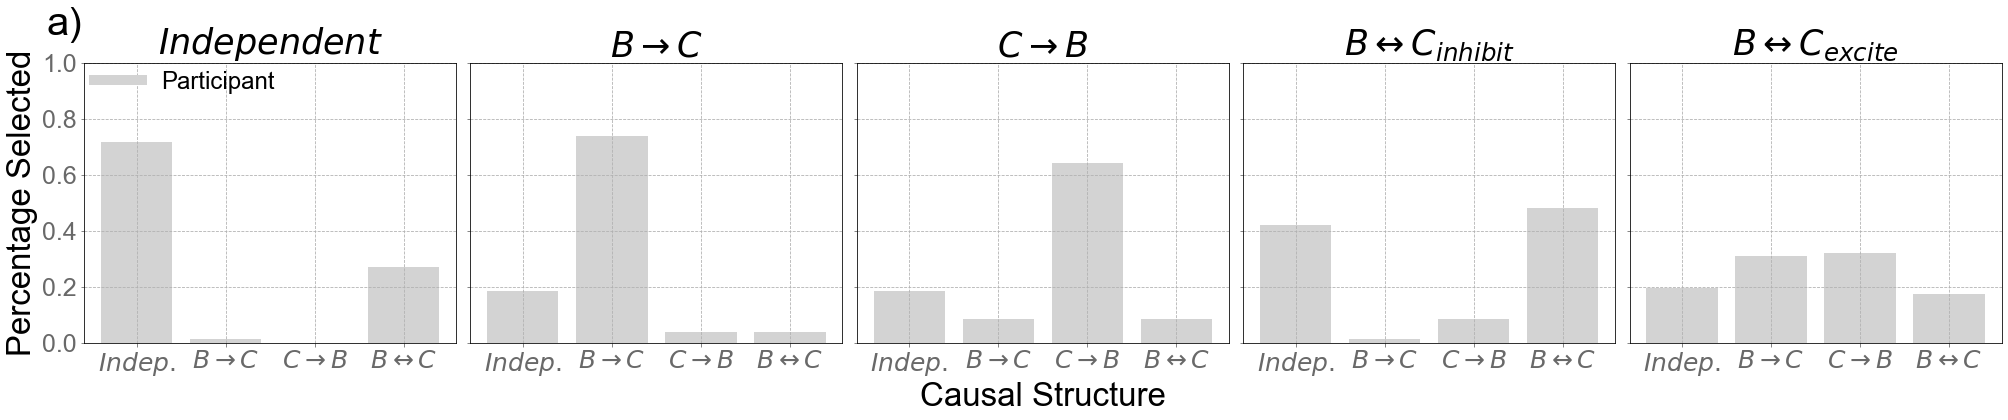

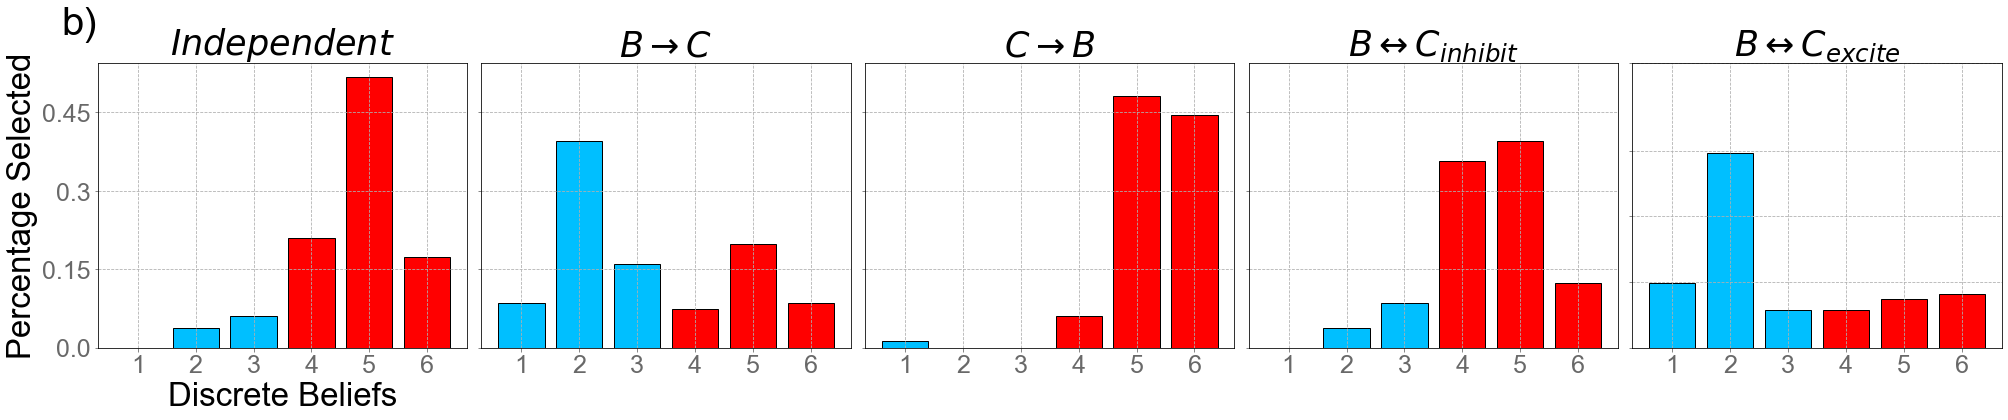

In [359]:
# ANALYSING STRUCTURE SELECTION
# DISCRETE BINS 
def plot_struct(subj_params,n_bins=4):
    fig, axs = plt.subplots(1, 5, figsize=(28,6),sharey=True) 
#     fig.delaxes(axs[2,1])
    ax_pos = {'indep': [0], 'b->c': [1],'c->b': [2], 'b<->c': [3],'b<->c_echo': [4]} 
    bins = ['1','2','3','4','5','6'] 
    bins = ['1','2','3','4','5','6'] 
    bin_colors = ['deepskyblue','deepskyblue','deepskyblue','red','red','red']
    bin_alphas = np.repeat(1,6)
    fig_labels = {'indep': 'a)', 'b->c': 'b)','c->b': 'c)', 'b<->c': 'd)','b<->c_echo': 'e)'} 
    fig_heading = {'indep': r'$Independent$', 'b->c': r'$B\rightarrow C$','c->b': r'$C\rightarrow B$', 'b<->c': r'$B\leftrightarrow C_{inhibit}$','b<->c_echo': r'$B\leftrightarrow C_{excite}$'}
#     plt.suptitle('Continuous Model Predictions', y=1.03, fontsize=20)

    for param in list(subj_params.keys()):
        # CREATING SPECIFIC PLOTS
        bins_subj = subj_params[param]
        

        # SPECIFIC PLOT COMPONENTS
        axs[ax_pos[param][0]].set_ylim([0, 1])
        axs[ax_pos[param][0]].grid(True, ls='--')
        axs[ax_pos[param][0]].title.set_text(fig_heading[param])
        axs[ax_pos[param][0]].bar([1,2,3,4],bins_subj,color='lightgrey',alpha=1,linewidth=4)
        axs[ax_pos[param][0]].set_xticks(np.arange(1,5)) 
        axs[ax_pos[param][0]].set_xticklabels([r'$Indep.$',r'$B\rightarrow C$',r'$C\rightarrow B$',r'$B\leftrightarrow C$']) 
        
#         if ax_pos[param][0] == 0: 
        if ax_pos[param][0] == 2: 
            axs[ax_pos[param][0]].set_xlabel('Causal Structure') 
        if ax_pos[param][0] == 0: 
            axs[ax_pos[param][0]].set_ylabel('Percentage Selected')
       
        # CUSTOMISE BINS AND TICKS FOR EACH PLOT
        if ax_pos[param][0] == 0: 
            axs[ax_pos[param][0]].text(-0.1, 1.1,'a)', transform=axs[ax_pos[param][0]].transAxes, 
            size=40)   
        from matplotlib.lines import Line2D
        custom_lines = [Line2D([0], [0], color='lightgrey', lw=10),
                Line2D([0], [0], color='Orange',linestyle='--',lw=5),
                Line2D([0], [0], color='Green',linestyle='--',lw=5)]
        
        if ax_pos[param][0] == 0:
            axs[ax_pos[param][0]].legend([custom_lines[0]],['Participant'],loc='upper left', bbox_to_anchor=(-0.03, 1.05), ncol=1,fontsize=24,frameon=False)
#              
    
    fig.tight_layout()
    plt.savefig('structure_selection.pdf') 
    plt.show()



# GETTING FREQUENCIES FOR MOD STRUCTURES
def struct_counts(bins,n_bins=4):
    indep_count = bins.count('independent')
    bc_count = bins.count('b->c')
    cb_count = bins.count('c->b')
    both_count = bins.count('b<->c')
    both_count += bins.count('b<->c_echo')
    counts = [indep_count,bc_count,cb_count,both_count]
    print(counts)
    norm_counts = [i/sum(counts) for i in counts]
    return norm_counts


struct_bins_subj = {}  
for cond in subjs_structure.keys(): 
    cond_c = cond
    if cond == 'independent':
        cond_c = 'indep'
    
    struct_bins_subj[cond_c] = list(struct_counts(subjs_structure[cond]))

print(struct_bins_subj)
plot_struct(struct_bins_subj)


# PLOTTING SUBJECTS SELECTIONS ONLY
def plot_bins_subj(params,n_bins=6):
    fig, axs = plt.subplots(1, 5, figsize=(28,6),sharey=True) 
#     fig.delaxes(axs[2,1])
    ax_pos = {'indep': [0], 'b->c': [1],'c->b': [2], 'b<->c': [3],'b<->c_echo': [4]} 
    bins = ['1','2','3','4','5','6'] 
    bin_colors = ['deepskyblue','deepskyblue','deepskyblue','red','red','red']
    bin_alphas = np.repeat(1,6)
    fig_labels = {'indep': 'a)', 'b->c': 'b)','c->b': 'c)', 'b<->c': 'd)','b<->c_echo': 'e)'} 
    fig_heading = {'indep': r'$Independent$', 'b->c': r'$B\rightarrow C$','c->b': r'$C\rightarrow B$', 'b<->c': r'$B\leftrightarrow C_{inhibit}$','b<->c_echo': r'$B\leftrightarrow C_{excite}$'}
#     plt.suptitle('Continuous Model Predictions', y=1.03, fontsize=20)

    for param in list(params.keys()):
        # CREATING SPECIFIC PLOTS
        
        bins_subj = params[param]
        bins = bins_subj
      
        

        # SPECIFIC PLOT COMPONENTS
        axs[ax_pos[param][0]].bar(0, bins[0],color=['deepskyblue'],alpha=1,edgecolor='black')
        
        axs[ax_pos[param][0]].bar(1, bins[1],color=['deepskyblue'],alpha=1,edgecolor='black')
        
        axs[ax_pos[param][0]].bar(2, bins[2],color=['deepskyblue'],alpha=1,edgecolor='black')
        
        axs[ax_pos[param][0]].bar(3, bins[3],color=['red'],alpha=1,edgecolor='black')
        
        axs[ax_pos[param][0]].bar(4, bins[4],color=['red'],alpha=1,edgecolor='black')
        
        axs[ax_pos[param][0]].bar(5, bins[5],color=['red'],alpha=1,edgecolor='black')
        
        axs[ax_pos[param][0]].grid(True, ls='--')
#         axs[ax_pos[param][0],ax_pos[param][1]].set_ylim([0, 0.5])
        
        axs[ax_pos[param][0]].title.set_text(fig_heading[param])
        axs[ax_pos[param][0]].set_xticks(np.arange(0,6)) 
        axs[ax_pos[param][0]].set_xticklabels(np.arange(1,7)) 
        axs[ax_pos[param][0]].set_yticks(np.arange(0,max(bins),max(bins)/6))
        axs[ax_pos[param][0]].set_yticklabels([np.round(i,2) for i in np.arange(0,max(bins),max(bins)/6)])
        
        if ax_pos[param][0] == 0: 
             axs[ax_pos[param][0]].set_xlabel('Discrete Beliefs') 
        if ax_pos[param][0] == 0: 
            axs[ax_pos[param][0]].set_ylabel('Percentage Selected')
        axs[ax_pos[param][0]].set_yticks([0.00,0.15,0.30,0.45,0.65])
        axs[ax_pos[param][0]].set_yticklabels([0.00,0.15,0.30,0.45,0.60])
        
#          CUSTOMISE BINS AND TICKS FOR EACH PLOT
        if ax_pos[param][0] == 0: 
            axs[ax_pos[param][0]].text(-0.1, 1.1,'b)', transform=axs[ax_pos[param][0]].transAxes, 
                size=40)    
    
    fig.tight_layout()
#     plt.savefig('subject_selections.pdf') 
    plt.show()

plot_bins_subj(param_bins_subj)

In [360]:
# SPECIFIC MODEL PARAMETER BINS AGAIN NOW PLAYING WITH A AND B FOR DIFFERENT LEARNERS 
param_bins_mod_naive = {} 
mod_param_final_naive = {} 

param_bins_mod_exact = {} 
mod_param_final_exact = {} 

param_bins_mod_init_fish = {} 
mod_param_final_init_fish = {} 

param_bins_mod_baseline = {} 
mod_param_final_baseline = {} 

param_bins_mod_influenced = {} 
mod_param_final_influenced = {} 

param_bins_mod_influencer = {} 
mod_param_final_influencer = {} 


for cond in mod_data.keys(): 
    # NAIVE
    a_N = mod_data[cond][9]['0']['a'] 
    b_N = mod_data[cond][9]['0']['b'] 
    # EXACT
    a_E = 3
    b_E = 2
    # BASELINE
    a_B = 1
    b_B = 1
    # INIT FISH
    a_I = 2
    b_I = 1
    # INFLUENCED
    a_IN = mod_data[cond][9]['2']['a'] 
    b_IN = mod_data[cond][9]['2']['b'] 
    # INFLUENCER
    a_IR = mod_data[cond][9]['2']['a'] 
    b_IR = mod_data[cond][9]['2']['b']
    print(a_IN)
    print(a_IR)
    
    # APPENDING BINS
    
    mod_param_final_naive[cond] = {'a': a_N, 'b': b_N} 
    param_bins_mod_naive[cond] = create_beta_bins(a_N,b_N) 
    
    mod_param_final_exact[cond] = {'a': a_E, 'b': b_E} 
    param_bins_mod_exact[cond] = create_beta_bins(a_E,b_E) 
    
    mod_param_final_baseline[cond] = {'a': a_B, 'b': b_B} 
    param_bins_mod_baseline[cond] = create_beta_bins(a_B,b_B) 
    
    mod_param_final_init_fish[cond] = {'a': a_I, 'b': b_I} 
    param_bins_mod_init_fish[cond] = create_beta_bins(a_I,b_I)
    
    mod_param_final_influenced[cond] = {'a': a_IN, 'b': b_IN} 
    param_bins_mod_influenced[cond] = create_beta_bins(a_IN,b_IN)
    
    mod_param_final_influencer[cond] = {'a': a_IR, 'b': b_IR} 
    param_bins_mod_influencer[cond] = create_beta_bins(a_IR,b_IR)




# COMPUTING MODEL LIKELIHOODS 
def compute_ll(mod_bins, subj_bins,recode=False):
    ll_dict_cond = {} 
    ll_all = 0
    ll_dict_subj = {}
    
    # FOR STRUCTURE SPECIFIC ANALYSIS 
    ll_dict_subj_recoded_length = {}
    for cond in recoded_subjs_selection_4_cond.keys():
        ll_dict_subj_recoded_length[cond] = {}
        for subj in range(len(recoded_subjs_selection_4_cond[cond])):
            ll_dict_subj_recoded_length[cond][str(subj)] = 0            

    for subj in range(81):
        ll_dict_subj[str(subj)] = 0

    # COMPUTING LL FOR EACH CONDITION ACROSS SUBJECTS 
    if not recode:
        for cond in mod_bins.keys():
            print(cond)
            ll_list = []
            ll_dict_cond[cond] = {'ll': 0, 'error': 0}
            cond_c = cond
            
            # RECODING CONDITION 
            if cond == 'indep':
                cond_c = 'independent'

            for selection in subj_bins[cond_c]:
                ll_dict_cond[cond]['ll'] += np.log(mod_bins[cond][selection-1])
                ll_list.append(mod_bins[cond][selection-1])
            ll_dict_cond[cond]['error'] = np.log(sem(ll_list))
            ll_all += ll_dict_cond[cond]['ll']

            # COMPUTING LL FOR EACH SUBJECT ACROSS CONDITIONS 
            for subj in range(81):
                selection2 = subj_bins[cond_c][subj]
                ll_dict_subj[str(subj)] += np.log(mod_bins[cond][selection2-1])
                
            cond_c_3 = cond_c
            if cond_c_3 == 'b<->c_echo':
                cond_c_3 = 'b<->c'
            for subj in range(len(recoded_subjs_selection_4_cond[cond_c_3])):
                selection2 = recoded_subjs_selection_4_cond[cond_c_3][subj]
                cond_c_4 = cond_c_3
                if cond_c_3 == 'independent':
                    cond_c_4 = 'indep'
                
                ll_dict_subj_recoded_length[cond_c_3][str(subj)] += np.log(mod_bins[cond_c_4][selection2-1])
   
    if recode: 
        for cond in mod_bins.keys():
            ll_list = []
            ll_dict_cond[cond] = {'ll': 0, 'error': 0}
            cond_c = cond
            
            # RECODING CONDITION 
            if cond == 'indep':
                cond_c = 'independent'
                
            for selection,structure in zip(subj_bins[cond_c],subjs_structure[cond_c]):
                structure_c = structure

               
                if structure == 'independent':
                    structure_c = 'indep'
               
                if structure_c not in ll_dict_cond.keys():
                    ll_dict_cond[structure_c] = {'ll': 0, 'error': 0}
                
                ll_dict_cond[structure_c]['ll'] += np.log(mod_bins[cond][selection-1])
                ll_list.append(mod_bins[cond][selection-1])
#             ll_dict_cond[cond]['error'] = np.log(sem(ll_list))
#             ll_all += ll_dict_cond[cond]['ll']

            # COMPUTING LL FOR EACH SUBJECT ACROSS CONDITIONS 
            
            for subj in range(81):
                structure = subjs_structure[cond_c][subj]
                structure_c = structure
                if structure == 'independent':
                    structure_c = 'indep'
                selection2 = subj_bins[cond_c][subj]
                ll_dict_subj[str(subj)] += np.log(mod_bins[structure_c][selection2-1])
                


    return {'ll_cond': ll_dict_cond, 'll_all': ll_all, 'll_subj': ll_dict_subj, 'll_subj_recode': ll_dict_subj_recoded_length}

# CREATING DICTS FOR EACH MODEL 
ll_dict_exact = compute_ll(param_bins_mod_exact,subjs_selection)
ll_dict_naive = compute_ll(param_bins_mod_combined,subjs_selection)
ll_dict_baseline = compute_ll(param_bins_mod_baseline,subjs_selection)
ll_dict_init_fish = compute_ll(param_bins_mod_init_fish,subjs_selection)
# ll_dict_influenced = compute_ll(param_bins_mod_influenced,subjs_selection)
# ll_dict_influencer = compute_ll(param_bins_mod_influencer,subjs_selection)


ll_dict_recoded_exact = compute_ll(param_bins_mod_exact,subjs_selection,recode=True)
ll_dict_recoded_naive = compute_ll(param_bins_mod_naive,subjs_selection,recode=True)
ll_dict_recoded_baseline = compute_ll(param_bins_mod_baseline,subjs_selection,recode=True)
ll_dict_recoded_init_fish = compute_ll(param_bins_mod_init_fish,subjs_selection,recode=True)
ll_dict_recoded_influenced = compute_ll(param_bins_mod_influenced,subjs_selection,recode=True)
# ll_dict_recoded_influenced = compute_ll(param_bins_mod_influencer,subjs_selection,recode=True)


# WRITING MODEL PERFORMANCE TO JSON 
# FIRST FOR CONDITION INDEPENDENT OF STRUCTURE 
print("STRUCTURE INDEPENDENT PER COND")
with open('model_ll/naive_per_cond.txt', 'w') as file:
    file.write(json.dumps(ll_dict_naive['ll_cond'])) 

with open('model_ll/exact_per_cond.txt', 'w') as file:
    file.write(json.dumps(ll_dict_exact['ll_cond'])) 
    
with open('model_ll/baseline_per_cond.txt', 'w') as file:
    file.write(json.dumps(ll_dict_baseline['ll_cond'])) 

with open('model_ll/init_fish_per_cond.txt', 'w') as file:
    file.write(json.dumps(ll_dict_init_fish['ll_cond'])) 

with open('model_ll/influenced_per_cond.txt', 'w') as file:
    file.write(json.dumps(ll_dict_influenced['ll_cond']))
    
with open('model_ll/influencer_per_cond.txt', 'w') as file:
    file.write(json.dumps(ll_dict_influencer['ll_cond']))
    
print(ll_dict_baseline['ll_all'])
print(ll_dict_init_fish['ll_all'])
print(ll_dict_exact['ll_all'])
print(ll_dict_naive['ll_all'])

# THEN PER STUBJECT
with open('model_ll/naive_per_subj.txt', 'w') as file:
    file.write(json.dumps(ll_dict_naive['ll_subj'])) 

with open('model_ll/exact_per_subj.txt', 'w') as file:
    file.write(json.dumps(ll_dict_exact['ll_subj'])) 
    
with open('model_ll/baseline_per_subj.txt', 'w') as file:
    file.write(json.dumps(ll_dict_baseline['ll_subj'])) 

with open('model_ll/init_fish_per_subj.txt', 'w') as file:
    file.write(json.dumps(ll_dict_init_fish['ll_subj'])) 

with open('model_ll/influenced_per_subj.txt', 'w') as file:
    file.write(json.dumps(ll_dict_influenced['ll_subj']))

with open('model_ll/influencer_per_subj.txt', 'w') as file:
    file.write(json.dumps(ll_dict_influencer['ll_subj']))

# WRITING MODEL PERFORMANCE TO JSON 
# NOW FOR CONDITION CONDIDERING STRUCTURE 
print("STRUCTURE DEPENDENT PER COND")
# with open('model_ll/naive_per_cond_recoded.txt', 'w') as file:
#     file.write(json.dumps(ll_dict_recoded_naive['ll_cond'])) 

# with open('model_ll/exact_per_cond_recoded.txt', 'w') as file:
#     file.write(json.dumps(ll_dict_recoded_exact['ll_cond'])) 
    
# with open('model_ll/baseline_per_cond_recoded.txt', 'w') as file:
#     file.write(json.dumps(ll_dict_recoded_baseline['ll_cond'])) 

# with open('model_ll/init_fish_per_cond_recoded.txt', 'w') as file:
#     file.write(json.dumps(ll_dict_recoded_init_fish['ll_cond'])) 
    
bics = []

# rawll = ll_dict_recoded_naive['ll_cond']
# print(ll_dict_recoded_naive)
# print(rawll.keys())
# for v in rawll.values():
#     bics.append(-2*v['ll'])
# print(bics)
# print(ll_dict_exact['ll_subj_recode'])
# print(ll_dict_recoded_init_fish['ll_cond'])
# print(ll_dict_recoded_exact['ll_cond'])
# print(ll_dict_recoded_naive['ll_cond'])

# THEN PER STUBJECT
with open('model_ll/naive_per_subj_recoded.txt', 'w') as file:
    file.write(json.dumps(ll_dict_naive['ll_subj_recode'])) 

with open('model_ll/exact_per_subj_recoded.txt', 'w') as file:
    file.write(json.dumps(ll_dict_exact['ll_subj_recode'])) 
    
with open('model_ll/baseline_per_subj_recoded.txt', 'w') as file:
    file.write(json.dumps(ll_dict_baseline['ll_subj_recode'])) 

with open('model_ll/init_fish_per_subj_recoded.txt', 'w') as file:
    file.write(json.dumps(ll_dict_init_fish['ll_subj_recode'])) 

with open('model_ll/influenced_per_subj_recoded.txt', 'w') as file:
    file.write(json.dumps(ll_dict_influenced['ll_subj_recode']))

with open('model_ll/influencer_per_subj_recoded.txt', 'w') as file:
    file.write(json.dumps(ll_dict_influencer['ll_subj_recode']))

print(len(recoded_subjs_selection_correct['independent']))
print(58/81)

2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
indep
b->c
c->b
b<->c
b<->c_echo
indep
b->c
c->b
b<->c
b<->c_echo
indep
b->c
c->b
b<->c
b<->c_echo
indep
b->c
c->b
b<->c
b<->c_echo
STRUCTURE INDEPENDENT PER COND
-725.6625850373621
-706.1326702979808
-723.31618293385
-647.5601383685287
STRUCTURE DEPENDENT PER COND
58
0.7160493827160493


In [361]:
# NEW LIKLIEHOOD PER PP CONDITIONED ON STRUCTURE
# COMPUTING MODEL LIKELIHOODS 
def compute_ll(mod_bins, subj_bins):
    ll_all = 0
    ll_dict_subj = {}
    
    # LOOPING OVER PP 
    for subj in range(81):
        ll_dict_subj[str(subj)] = 0

        # LOOPING OVER COND FOR EACH PP
        ll_subj = 0
        for cond in mod_bins.keys():
            cond_c = cond
            # RECODING CONDITION 
            if cond == 'indep':
                cond_c = 'independent'
                
            # NOW PICKCING SPECIFIC SELECTION ANS STRUCTURE
            selection = subj_bins[cond_c][subj]
            structure = subjs_structure[cond_c][subj]
            structure_c = structure
            if structure_c == 'independent':
                structure_c = 'indep'
            ll_subj += np.log(mod_bins[structure_c][selection-1])  # 
        
        ll_dict_subj[str(subj)] = ll_subj
    

    return ll_dict_subj

# CREATING DICTS FOR EACH MODEL 
ll_dict_subj_exact = compute_ll(param_bins_mod_exact,subjs_selection)
param_bins_mod_combined['b<->c_echo'] = param_bins_mod_combined['b<->c']
ll_dict_subj_naive = compute_ll(param_bins_mod_combined,subjs_selection)
ll_dict_subj_init = compute_ll(param_bins_mod_init_fish,subjs_selection)
ll_dict_subj_base = compute_ll(param_bins_mod_baseline,subjs_selection)


# RUNNING SUBJECT COMPARISON
scores = {'baseline': [], 'naive': [], 'normative': [], 'init_fish': [], 'influenced': [],'influencer': []}
sums = {'baseline': [], 'naive': [], 'normative': [], 'init_fish': [],'influenced': [],'influencer': []}
sum_base = []
sum_naive = []
sum_normative = []
sum_initfish = []
for subj in ll_dict_subj_exact.keys():
    baseline_score = ll_dict_subj_base[str(subj)]
    naive_score = ll_dict_subj_naive[str(subj)]
    normative_score = ll_dict_subj_exact[str(subj)]
    initfish_score = ll_dict_subj_init[str(subj)]
    sum_base.append(-2*baseline_score)
    sum_naive.append(-2*naive_score)
    sum_normative.append(-2*normative_score)
    sum_initfish.append(-2*initfish_score)
    
    if baseline_score >= naive_score and baseline_score >= normative_score and baseline_score >= initfish_score: 
        scores['baseline'].append(1)
        scores['naive'].append(0)
        scores['normative'].append(0)
        scores['init_fish'].append(0)
        
    elif naive_score > baseline_score and naive_score > normative_score and naive_score > initfish_score:
        scores['baseline'].append(0)
        scores['naive'].append(1)
        scores['normative'].append(0)
        scores['init_fish'].append(0)
       
    elif normative_score > baseline_score and normative_score >= naive_score and normative_score > initfish_score:
        scores['baseline'].append(0)
        scores['naive'].append(0)
        scores['normative'].append(1)
        scores['init_fish'].append(0)
       
    elif initfish_score >= baseline_score and initfish_score >= normative_score and initfish_score >= naive_score:
        scores['baseline'].append(0)
        scores['naive'].append(0)
        scores['normative'].append(0)
        scores['init_fish'].append(1)



print(sum(scores['baseline']))
print(sum(scores['init_fish']))
print(sum(scores['normative']))
print(sum(scores['naive']))    
# print(sum(scores['influenced']))
# print(sum(scores['influenced']))

print('cond_sums')
print(sum(sum_base))
print(sum(sum_initfish))
print(sum(sum_normative))
print(sum(sum_naive))


# NEW LIKLIEHOOD PER PP CONDITIONED ON STRUCTURE FOR CORRECT TRIALS 
# COMPUTING MODEL LIKELIHOODS 
def compute_ll(mod_bins, subj_bins):
    ll_all = 0
    ll_dict_trials = {}
    
    # LOOPING OVER PP 
    for cond in mod_bins.keys():
        cond_c = cond
        ll_dict_trials[cond] = {}
        # RECODING CONDITION 
        if cond == 'indep':
            cond_c = 'independent'
        
        for trial in range(len(subj_bins[cond_c])): 
            
            selection = subj_bins[cond_c][trial]
            ll_dict_trials[cond][str(trial)] = np.log(mod_bins[cond][selection-1])  # 
        
       
    return ll_dict_trials

# CREATING DICTS FOR EACH MODEL 
ll_dict_trial_exact = compute_ll(param_bins_mod_exact,recoded_subjs_selection)
param_bins_mod_combined['b<->c_echo'] = param_bins_mod_combined['b<->c']
ll_dict_trial_naive = compute_ll(param_bins_mod_naive,recoded_subjs_selection)
ll_dict_trial_init = compute_ll(param_bins_mod_init_fish,recoded_subjs_selection)
ll_dict_trial_base = compute_ll(param_bins_mod_baseline,recoded_subjs_selection)

# RUNNING TRIAL COMPARISON
scores = {'baseline': [], 'naive': [], 'normative': [], 'init_fish': [], 'influenced': [],'influencer': []}
sums = {'baseline': [], 'naive': [], 'normative': [], 'init_fish': [],'influenced': [],'influencer': []}
sum_base = []
sum_naive = []
sum_normative = []
sum_initfish = []
sum_base_all = []
sum_naive_all = []
sum_normative_all = []
sum_initfish_all = []

for cond in ll_dict_trial_exact.keys():
    for trial in ll_dict_trial_exact[cond].keys():
        baseline_score = ll_dict_trial_base[cond][str(trial)]
        naive_score = ll_dict_trial_naive[cond][str(trial)]
        normative_score = ll_dict_trial_exact[cond][str(trial)]
        initfish_score = ll_dict_trial_init[cond][str(trial)]

        sum_base.append(-2*baseline_score)
        sum_naive.append(-2*naive_score)
        sum_normative.append(-2*normative_score)
        sum_initfish.append(-2*initfish_score)

        if baseline_score >= naive_score and baseline_score >= normative_score and baseline_score >= initfish_score: 
            scores['baseline'].append(1)
            scores['naive'].append(0)
            scores['normative'].append(0)
            scores['init_fish'].append(0)

        elif naive_score > baseline_score and naive_score > normative_score and naive_score > initfish_score:
            scores['baseline'].append(0)
            scores['naive'].append(1)
            scores['normative'].append(0)
            scores['init_fish'].append(0)

        elif normative_score > baseline_score and normative_score >= naive_score and normative_score > initfish_score:
            scores['baseline'].append(0)
            scores['naive'].append(0)
            scores['normative'].append(1)
            scores['init_fish'].append(0)

        elif initfish_score >= baseline_score and initfish_score >= normative_score and initfish_score >= naive_score:
            scores['baseline'].append(0)
            scores['naive'].append(0)
            scores['normative'].append(0)
            scores['init_fish'].append(1)
    sum_base_all.append(sum(scores['baseline']))
    sum_initfish_all.append(sum(scores['init_fish']))
    sum_normative_all.append(sum(scores['normative']))
    sum_naive_all.append(sum(scores['naive']))
    scores['baseline'] = []
    scores['naive'] = []
    scores['normative'] = []
    scores['init_fish'] = []
    print('--------------------')
    print('cond_sums')
    print(sum(sum_base))
    print(sum_base_all)
    print(sum_initfish_all)
    print(sum_normative_all)
    print(sum_naive_all)
#     print('--------------------')
#     print(sum(scores['baseline']))
#     print(sum(scores['init_fish']))
#     print(sum(scores['normative']))
#     print(sum(scores['naive']))  
#     print('--------------------')
#     print('--------------------')

#     print(len(scores['baseline']))

# print(sum(scores['baseline']))
# print(sum(scores['init_fish']))
# print(sum(scores['normative']))
# print(sum(scores['naive']))    
# # print(sum(scores['influenced']))
# # print(sum(scores['influenced']))
print(sum(sum_base_all))
print(sum(sum_initfish_all))
print(sum(sum_normative_all))
print(sum(sum_naive_all))
print('cond_sums')
print(sum(sum_base))
print(sum(sum_initfish))
print(sum(sum_normative))
print(sum(sum_naive))



7
23
29
22
cond_sums
1451.3251700747244
1412.2653405959602
1446.632365867699
1473.8911237568484
--------------------
cond_sums
494.52561350694305
[21]
[26]
[56]
[35]
--------------------
cond_sums
831.3763937218173
[21, 7]
[26, 13]
[56, 34]
[35, 40]
--------------------
cond_sums
1146.726060305955
[21, 7, 23]
[26, 13, 0]
[56, 34, 7]
[35, 40, 58]
--------------------
cond_sums
1401.1559049363386
[21, 7, 23, 3]
[26, 13, 0, 11]
[56, 34, 7, 29]
[35, 40, 58, 28]
--------------------
cond_sums
1451.3251700747242
[21, 7, 23, 3, 3]
[26, 13, 0, 11, 0]
[56, 34, 7, 29, 2]
[35, 40, 58, 28, 9]
57
50
128
170
cond_sums
1451.3251700747242
1412.2653405959638
1446.632365867703
1463.8077997796918


In [362]:
print(sum([3, 5, 1, 2, 4]))
print(sum([11, 7, 0, 1, 2]))
print(sum([26, 17, 3, 21, 2]))
print(sum([18, 31, 48, 15, 6]))
print(sum([59,
50,
125,
171]))

15
21
69
118
405


In [348]:
print(recoded_subjs_selection_4_cond)

{'independent': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 'b->c': [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 'c->b': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 'b

In [349]:
print(subjs_selection)

{'independent': [2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 'b->c': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 'c->b': [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 'b<->c': [2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6

In [350]:
# COMPARING N BEST FIT COMPARED TO BASELINE IRRESPECTIVE OF STRUCTURE 

# BASELINE FITS 
baseline = open("model_ll/baseline_per_subj_recoded.txt", "r")
baseline = eval(baseline.read())

# INIT FISH FITS 
initfish = open("model_ll/init_fish_per_subj_recoded.txt", "r")
initfish = eval(initfish.read())

# NAIVE FITS
naive = open("model_ll/naive_per_subj_recoded.txt", "r")
naive = eval(naive.read())

# NORMATIVE FITS (EXACT FISH)
normative = open("model_ll/exact_per_subj_recoded.txt", "r")
normative = eval(normative.read())

influenced = open("model_ll/influenced_per_subj_recoded.txt", "r")
influenced = eval(influenced.read())

influencer = open("model_ll/influencer_per_subj_recoded.txt", "r")
influencer = eval(influencer.read())

# KEEPINg TRACK OF MODEL SCORES (I.E. WHICH WAS BEST AT DESCRIBING SPECIFIC SUBJRCT)
scores = {'baseline': [], 'naive': [], 'normative': [], 'init_fish': [], 'influenced': [],'influencer': []}
sums = {'baseline': [], 'naive': [], 'normative': [], 'init_fish': [],'influenced': [],'influencer': []}
sum_base = []
sum_naive = []
sum_normative = []
sum_initfish = []
for subj in baseline['independent'].keys():
    baseline_score = baseline['independent'][str(subj)]
    naive_score = naive['independent'][str(subj)]
    normative_score = normative['independent'][str(subj)]
    initfish_score = initfish['independent'][str(subj)]
#     influenced_score = influenced['c->b'][str(subj)]
    sum_base.append(-2*baseline_score)
    sum_naive.append(-2*naive_score)
    sum_normative.append(-2*normative_score)
    sum_initfish.append(-2*initfish_score)
    
    if baseline_score >= naive_score and baseline_score >= normative_score and baseline_score >= initfish_score: 
        scores['baseline'].append(1)
        scores['naive'].append(0)
        scores['normative'].append(0)
        scores['init_fish'].append(0)
        
    elif naive_score > baseline_score and naive_score > normative_score and naive_score > initfish_score:
        scores['baseline'].append(0)
        scores['naive'].append(1)
        scores['normative'].append(0)
        scores['init_fish'].append(0)
       
    elif normative_score > baseline_score and normative_score >= naive_score and normative_score > initfish_score:
        scores['baseline'].append(0)
        scores['naive'].append(0)
        scores['normative'].append(1)
        scores['init_fish'].append(0)
       
    elif initfish_score >= baseline_score and initfish_score >= normative_score and initfish_score >= naive_score:
        scores['baseline'].append(0)
        print('hi')
        scores['naive'].append(0)
        scores['normative'].append(0)
        scores['init_fish'].append(1)
        
    
#     elif influenced_score > baseline_score and influenced_score > normative_score and influenced_score > naive_score and influenced_score > initfish_score and influenced_score > influencer_score:
#         scores['baseline'].append(0)
#         scores['naive'].append(0)
#         scores['normative'].append(0)
#         scores['init_fish'].append(0)
#         scores['influenced'].append(1)
#         scores['influencer'].append(0)
    
#     elif influencer_score > baseline_score and influencer_score > normative_score and influencer_score > naive_score and influencer_score > initfish_score and influencer_score > influenced_score: 
#         scores['baseline'].append(0)
#         scores['naive'].append(0)
#         scores['normative'].append(0)
#         scores['init_fish'].append(0)
#         scores['influenced'].append(0)
#         scores['influencer'].append(1)



# sums['baseline'] = np.sum(list(baseline.values()))
# sums['naive'] = np.sum(list(naive.values()))
# sums['normative'] = np.sum(list(normative.values()))
# sums['init_fish'] = np.sum(list(initfish.values()))
print(sum(scores['baseline']))
print(sum(scores['init_fish']))
print(sum(scores['normative']))
print(sum(scores['naive']))    
# print(sum(scores['influenced']))
# print(sum(scores['influenced']))

print('cond_sums')
print(sum(sum_base))
print(sum(sum_initfish))
print(sum(sum_normative))
print(sum(sum_naive))


hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
21
26
56
35
cond_sums
494.52561350694305
453.6316612278882
461.98386792146556
480.53488126964703


In [351]:
# COMPARING N BEST FIT COMPARED TO BASELINE IRRESPECTIVE OF STRUCTURE 

# BASELINE FITS 
baseline = open("model_ll/baseline_per_subj.txt", "r")
baseline = eval(baseline.read())

# INIT FISH FITS 
initfish = open("model_ll/init_fish_per_subj.txt", "r")
initfish = eval(initfish.read())

# NAIVE FITS
naive = open("model_ll/naive_per_subj.txt", "r")
naive = eval(naive.read())

# NORMATIVE FITS (EXACT FISH)
normative = open("model_ll/exact_per_subj.txt", "r")
normative = eval(normative.read())

# KEEPINg TRACK OF MODEL SCORES (I.E. WHICH WAS BEST AT DESCRIBING SPECIFIC SUBJRCT)
scores = {'baseline': [], 'naive': [], 'normative': [], 'init_fish': []}
sums = {'baseline': [], 'naive': [], 'normative': [], 'init_fish': []}

for subj in baseline.keys():
    baseline_score = baseline[str(subj)]
    naive_score = naive[str(subj)]
    normative_score = normative[str(subj)]
    initfish_score = initfish[str(subj)]
    
    if baseline_score > naive_score and baseline_score > normative_score and baseline_score > initfish_score:
        scores['baseline'].append(1)
        scores['naive'].append(0)
        scores['normative'].append(0)
        scores['init_fish'].append(0)
    elif naive_score > baseline_score and naive_score > normative_score and naive_score > initfish_score: 
        scores['baseline'].append(0)
        scores['naive'].append(1)
        scores['normative'].append(0)
        scores['init_fish'].append(0)
    elif normative_score > baseline_score and normative_score > naive_score and normative_score > initfish_score: 
        scores['baseline'].append(0)
        scores['naive'].append(0)
        scores['normative'].append(1)
        scores['init_fish'].append(0)
    elif initfish_score > baseline_score and initfish_score > normative_score and initfish_score > naive_score: 
        scores['baseline'].append(0)
        scores['naive'].append(0)
        scores['normative'].append(0)
        scores['init_fish'].append(1)


# sums['baseline'] = np.sum(list(baseline.values()))
# sums['naive'] = np.sum(list(naive.values()))
# sums['normative'] = np.sum(list(normative.values()))
# sums['init_fish'] = np.sum(list(initfish.values()))
print(sum(scores['baseline']))
print(sum(scores['init_fish']))
print(sum(scores['normative']))
print(sum(scores['naive']))    


16
23
42
0


In [352]:
# PLOTTING MODEL PERFORMANCE FOR EACH OF OUR LEARNERS (NAÏVE, INFLUENCER, INFLUENCED, INITIAL FISH)
def plot_ll_learners(mod_params,n_bins=4):
    fig, axs = plt.subplots(2, 2, figsize=(6,6),sharey=True) 
    ax_pos = {'naïve': [0,0], 'influencer': [0,1],'influenced': [1,0], 'init_fish': [1,1]} 
    bin_colors = ['pink']
    bin_alphas = np.repeat(1,4)
    fig_labels = {'naïve': '', 'influencer': '','influenced': '', 'init_fish': ''} 
    fig_heading = {'naïve': r'$Naïve-Learner$', 'influencer': r'$Influencer$','influenced': r'$Influenced$', 'init_fish': r'$Baseline$'} 
#     plt.suptitle('Naïve Learner', y=1.03, fontsize=20)
    
    for param in list(mod_params.keys()):
        # CREATING SPECIFIC PLOTS
        mod_bins = []
        error = []
        for cond in mod_params[param]:
            mod_bins.append(-mod_params[param][cond]['ll'])
            error.append(-mod_params[param][cond]['error'])
        
        
        

        # SPECIFIC PLOT COMPONENTS
        axs[ax_pos[param][0],ax_pos[param][1]].title.set_text(fig_heading[param])
        axs[ax_pos[param][0],ax_pos[param][1]].bar([1,2,3,4],mod_bins,edgecolor='black',color='maroon',alpha=1)
        axs[ax_pos[param][0],ax_pos[param][1]].set_xticks(np.arange(1,5)) 
        axs[ax_pos[param][0],ax_pos[param][1]].set_xticklabels([r'$indep.$',r'$B\rightarrow C$',r'$C\rightarrow B$',r'$B\leftrightarrow C$'],size=12) 

        if ax_pos[param][0] == 1: 
            axs[ax_pos[param][0],ax_pos[param][1]].set_xlabel('Causal Structure') 
        if ax_pos[param][1] == 0: 
            axs[ax_pos[param][0],ax_pos[param][1]].set_ylabel('Negative LogLikelihood')
        
        # CUSTOMISE BINS AND TICKS FOR EACH PLOT
        axs[ax_pos[param][0],ax_pos[param][1]].text(-0.1, 1.03,fig_labels[param], transform=axs[ax_pos[param][0],ax_pos[param][1]].transAxes, 
            size=20,fontweight='bold')    
    
    fig.tight_layout()
    plt.savefig('mod_comparison_per_condition.pdf') 
    plt.show()


# LOADING PARAMETERS 
naïve = open("naïve.txt", "r")
naïve = eval(naïve.read())


influencer = open("influencer.txt", "r")
influencer = eval(influencer.read())


influenced = open("influenced.txt", "r")
influenced = eval(influenced.read())


init_fish = open("init_fish.txt", "r")
init_fish = eval(init_fish.read())


# LOADING RECODED PARAMETERS
naïve_r = open("naïve_recoded.txt", "r")
naïve_r = eval(naïve_r.read())


influencer_r = open("influencer_recoded.txt", "r")
influencer_r = eval(influencer_r.read())


influenced_r = open("influenced_recoded.txt", "r")
influenced_r = eval(influenced_r.read())


init_fish_r = open("init_fish_recoded.txt", "r")
init_fish_r = eval(init_fish_r.read())



# PLOTTING MODEL PERFORMANCE PER CONDITION 
mod_performance = {'naïve': naïve, 'influencer': influencer, 'influenced': influenced, 'init_fish': init_fish}
mod_performance_r = {'naïve': naïve_r, 'influencer': influencer_r, 'influenced': influenced_r, 'init_fish': init_fish_r}
plot_ll_learners(mod_performance)
# plot_ll_learners(mod_performance_r)

print(mod_performance)

overall_ll = {}
for learner in mod_performance.keys():
    overall_ll[learner] = 0
    for cond in mod_performance[learner]:
        overall_ll[learner] += mod_performance[learner][cond]['ll']

print(overall_ll)

# overall_ll_r = {}
# for learner in mod_performance_r.keys():
#     overall_ll_r[learner] = 0
#     for cond in mod_performance_r[learner]:
#         overall_ll_r[learner] += mod_performance_r[learner][cond]['ll']

# print(overall_ll_r)

FileNotFoundError: [Errno 2] No such file or directory: 'naïve.txt'

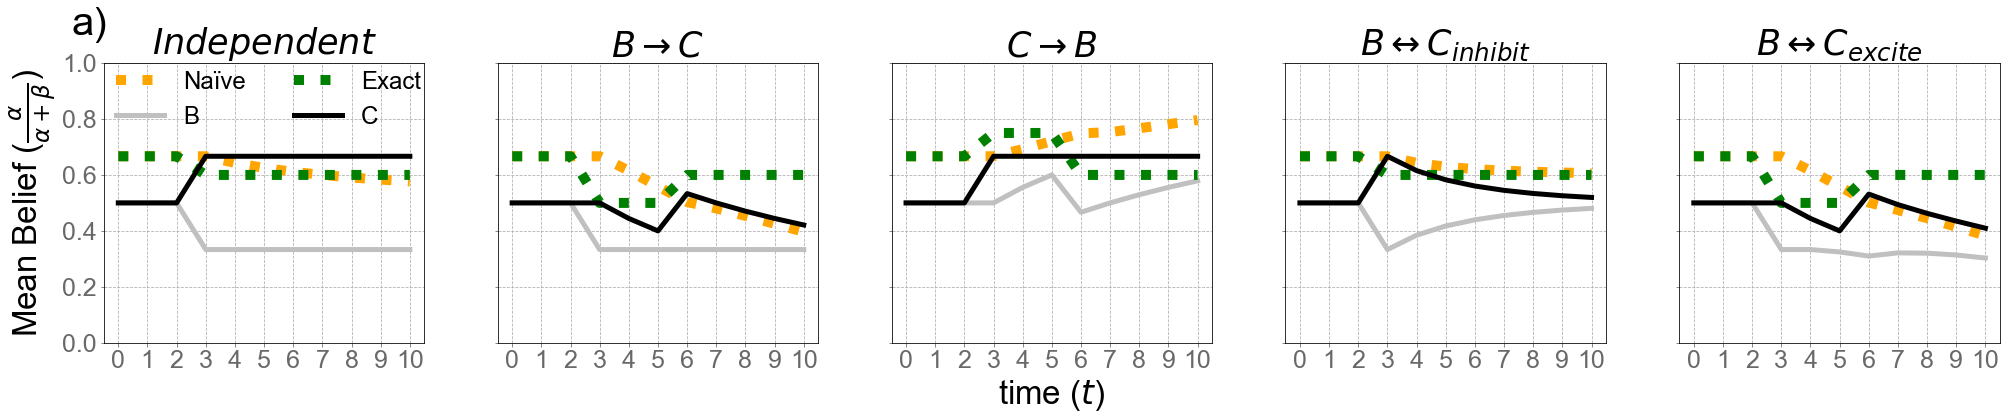

[[[2.0, 1.0], [1.0, 1.0], [1.0, 1.0], [2.0, 1.0]], [[2.0, 1.0], [1.0, 1.0], [1.0, 1.0], [2.0, 1.0]], [[2.0, 1.0], [1.0, 1.0], [1.0, 1.0], [2.0, 1.0]], [[2.0, 1.0], [1.0, 2.0], [2.0, 1.0], [3.0, 2.0]], [[2.25, 1.25], [1.0, 2.0], [2.0, 1.0], [3.0, 2.0]], [[2.5, 1.5], [1.0, 2.0], [2.0, 1.0], [3.0, 2.0]], [[2.75, 1.75], [1.0, 2.0], [2.0, 1.0], [3.0, 2.0]], [[3.0, 2.0], [1.0, 2.0], [2.0, 1.0], [3.0, 2.0]], [[3.25, 2.25], [1.0, 2.0], [2.0, 1.0], [3.0, 2.0]], [[3.5, 2.5], [1.0, 2.0], [2.0, 1.0], [3.0, 2.0]], [[3.75, 2.75], [1.0, 2.0], [2.0, 1.0], [3.0, 2.0]]]


In [353]:
# PLOTTING SIMULATED SEQUENCES FROM MODEL 
mod_beliefs = open('../model/notebooks/naïve_mod_beliefs.txt')
mod_beliefs = json.load(mod_beliefs)

def beta_mean_var(a,b):
    mean = a / (a+b)
    var = (a*b)/((a+b)**2 * (a+b+1))
    return mean, var

def plot_learner_simulations(mod_params,n_bins=4):
    fig, axs = plt.subplots(1, 5, figsize=(28,6),sharey=True) 
#     fig.delaxes(axs[2,1])
    ax_pos = {'indep': [0], 'b->c': [1],'c->b': [2], 'b<->c': [3],'b<->c_echo': [4]} 
    bins = ['1','2','3','4','5','6'] 
    bin_colors = ['deepskyblue','deepskyblue','deepskyblue','red','red','red']
    bin_alphas = np.repeat(1,6)
    fig_labels = {'indep': 'a)', 'b->c': 'b)','c->b': 'c)', 'b<->c': 'd)','b<->c_echo': 'e)'} 
    fig_heading = {'indep': r'$Independent$', 'b->c': r'$B\rightarrow C$','c->b': r'$C\rightarrow B$', 'b<->c': r'$B\leftrightarrow C_{inhibit}$','b<->c_echo': r'$B\leftrightarrow C_{excite}$'}
#     plt.suptitle('Continuous Model Predictions', y=1.03, fontsize=20)
    for param in list(mod_params.keys()):
        # CREATING SPECIFIC PLOTS
        df = {}
        for agent in range(np.array(mod_params[param]).shape[1]):
            mean = []
            var = []
            for e in np.array(mod_params[param])[:,agent,:]:
                m,v = beta_mean_var(e[0],e[1])
                mean.append(m)
                var.append(v)
            df[str(agent) + "_mean"] = mean
    

        df = pd.DataFrame(df)
        axs[ax_pos[param][0]].title.set_text(fig_heading[param])
        axs[ax_pos[param][0]].plot(np.arange(0, 11,1), df["0_mean"], label="Naïve",linewidth=10, color='orange',linestyle="dotted")
        axs[ax_pos[param][0]].plot(np.arange(0, 11,1), df["1_mean"], label="B",linewidth=5,color='silver')
        axs[ax_pos[param][0]].plot(np.arange(0, 11,1), df["3_mean"], label="Exact",linestyle="dotted",linewidth=10,color='green')
        
        axs[ax_pos[param][0]].plot(np.arange(0, 11,1), df["2_mean"], label="C ",linewidth=5,color='black')
        axs[ax_pos[param][0]].set_ylim([0, 1])
        
        axs[ax_pos[param][0]].grid(True, ls='--')
#         axs[ax_pos[param][0]].axhline(0.5, color='grey', linestyle="dotted")
        
        # CUSTOMISE BINS AND TICKS FOR EACH PLOT
        if ax_pos[param][0] == 0: 
            axs[ax_pos[param][0]].text(-0.1, 1.1,'a)', transform=axs[ax_pos[param][0]].transAxes, 
            size=40)   
    
    


        if ax_pos[param][0] == 2: 
            axs[ax_pos[param][0]].set_xlabel(r'time ($t$)') 
            
        axs[ax_pos[param][0]].set_xticks([0,1,2,3,4,5,6,7,8,9,10])
        if ax_pos[param][0] == 0: 
            axs[ax_pos[param][0]].set_ylabel(r'Mean Belief ($\frac{\alpha}{\alpha+\beta}$)')
            if ax_pos[param][0] == 0:
                axs[ax_pos[param][0]].legend(loc='upper left', bbox_to_anchor=(-0.03, 1.05), ncol=2,fontsize=24,frameon=False)
#                 plt.axhline(0.5, color='red', linestyle="dotted")
                
    fig.tight_layout()
    plt.savefig('naïve_mod_simulations.pdf') 
    plt.show()

plot_learner_simulations(mod_beliefs)
print(mod_beliefs['indep'])

[0.13570749576958138, 0.3570596025882619, 0.47244015545583695, 0.4789427355292839, 0.3820963482361215, 0.1737536624209144]
0.018201486917869342
0.11750600885171203
[0.06785374788479069, 0.17852980129413096, 0.23622007772791848, 0.23947136776464195, 0.19104817411806074, 0.0868768312104572]
{'indep': [0.011915553219199293, 0.09413158103533886, 0.22418759311410685, 0.31078976862513574, 0.2689515783955603, 0.09002392561065897], 'b->c': [0.10993824941842623, 0.25194455763172313, 0.27831578418772956, 0.21926095031923554, 0.11654269634634307, 0.023997762096542474], 'c->b': [0.0012745535279745802, 0.016058349058828948, 0.06197193422729697, 0.15240624958529433, 0.2952909025934558, 0.47299801100714933], 'b<->c': [0.06785374788479069, 0.17852980129413096, 0.23622007772791848, 0.23947136776464195, 0.19104817411806074, 0.0868768312104572], 'b<->c_echo': [0.06785374788479069, 0.17852980129413096, 0.23622007772791848, 0.23947136776464195, 0.19104817411806074, 0.0868768312104572]}


<ipython-input-354-7ddd0acf7bfc>:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  red_patch = mpatches.Patch(color='orange', label='The red data',linestyle='--',edgecolor='green')


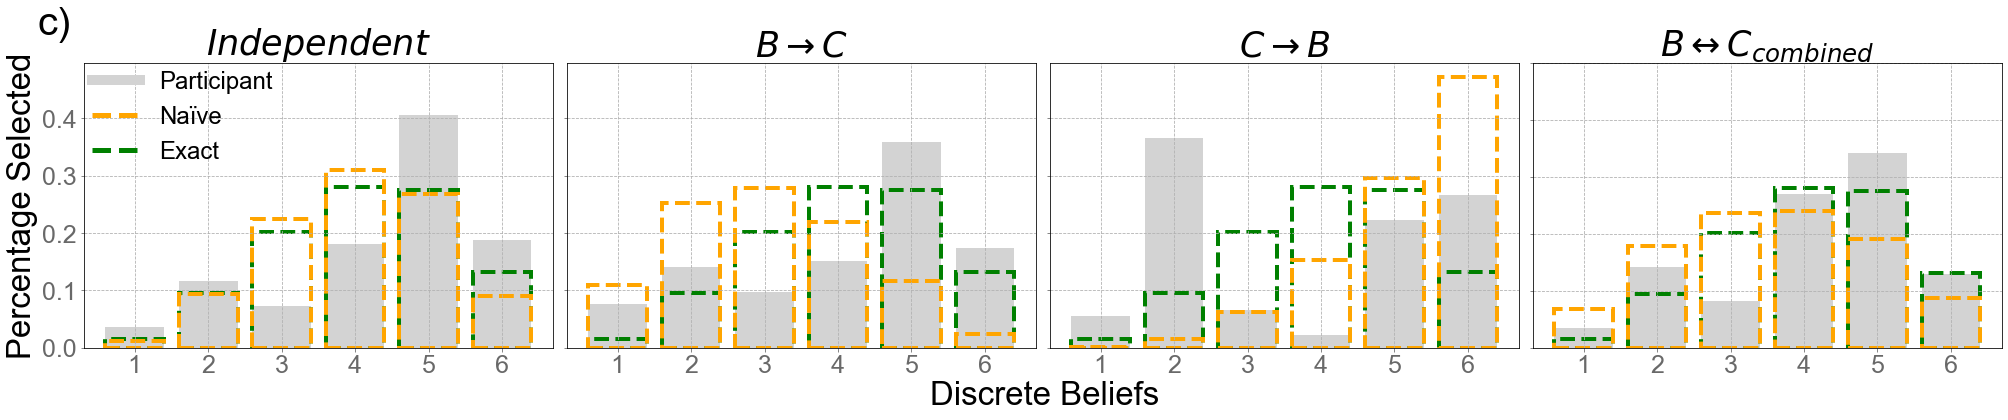

In [354]:
# PLOTTING PLANET SELECTION CONDITIONAL ON STRUCTURE  (NOW ONLY 4 PANELS)
# DISCRETE BETA
import matplotlib.patches as mpatches
def plot_bins(params,subj_params,params_exact,n_bins=6):
    fig, axs = plt.subplots(1, 4, figsize=(28,6),sharey=True,sharex=True) 
#     fig.delaxes(axs[2,1])
    ax_pos = {'indep': [0], 'b->c': [1],'c->b': [2], 'b<->c': [3]} 
    bins = ['1','2','3','4','5','6'] 
    bin_colors = ['deepskyblue','deepskyblue','deepskyblue','red','red','red']
    bin_alphas = np.repeat(1,6)
    fig_labels = {'indep': 'a)', 'b->c': 'b)','c->b': 'c)', 'b<->c': 'd)'} 
    fig_heading = {'indep': r'$Independent$', 'b->c': r'$B\rightarrow C$','c->b': r'$C\rightarrow B$', 'b<->c': r'$B\leftrightarrow C_{combined}$'}
#     plt.suptitle('Continuous Model Predictions', y=1.03, fontsize=20)

    
    for param in list(subj_params.keys()):
        # CREATING SPECIFIC PLOTS
        bins_n = params[param]
        bins = params_exact
        bins_subj = subj_params[param]
        axs[ax_pos[param][0]].grid(True, ls='--')
        

        # SPECIFIC PLOT COMPONENTS
        
        axs[ax_pos[param][0]].bar(0, bins_subj[0],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(0, bins[0],color=['deepskyblue'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(0, bins_n[0],color=['deepskyblue'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        
        
        axs[ax_pos[param][0]].bar(1, bins_subj[1],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(1, bins[1],color=['deepskyblue'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(1, bins_n[1],color=['deepskyblue'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        axs[ax_pos[param][0]].bar(2, bins_subj[2],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(2, bins[2],color=['deepskyblue'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(2, bins_n[2],color=['deepskyblue'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        axs[ax_pos[param][0]].bar(3, bins_subj[3],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(3, bins[3],color=['red'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(3, bins_n[3],color=['deepskyblue'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        axs[ax_pos[param][0]].bar(4, bins_subj[4],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(4, bins[4],color=['red'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(4, bins_n[4],color=['deepskyblue'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        axs[ax_pos[param][0]].bar(5, bins_subj[5],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(5, bins[5],color=['red'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(5, bins_n[5],color=['deepskyblue'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        
#         axs[ax_pos[param][0]].title.set_text(fig_heading[param])
        axs[ax_pos[param][0]].set_xticks(np.arange(0,6)) 
        axs[ax_pos[param][0]].set_xticklabels(np.arange(1,7)) 
        axs[ax_pos[param][0]].set_yticks(np.arange(0,max(bins_subj),max(bins_subj)/6))
#         axs[ax_pos[param][0]].set_yticklabels([np.round(i,2) for i in np.arange(0,max(bins_subj),max(bins_subj)/6)])
        axs[ax_pos[param][0]].set_yticks(np.arange(0,0.6,0.1))
        axs[ax_pos[param][0]].title.set_text(fig_heading[param])
        if ax_pos[param][0] == 2: 
            axs[ax_pos[param][0]].set_xlabel(';',color='white') 
        if ax_pos[param][0] == 0: 
            axs[ax_pos[param][0]].set_ylabel('Percentage Selected')
        
#         # CUSTOMISE BINS AND TICKS FOR EACH PLOT
        if ax_pos[param][0] == 0: 
            axs[ax_pos[param][0]].text(-0.1, 1.1,'c)', transform=axs[ax_pos[param][0]].transAxes, 
            size=40)   
#     plt.xlabel('Discrete Beliefs')
        red_patch = mpatches.Patch(color='orange', label='The red data',linestyle='--',edgecolor='green')
#         plt.legend(handles=[red_patch])
        labels = ['Participant','Naïve','Exact','d']
        from matplotlib.lines import Line2D
        custom_lines = [Line2D([0], [0], color='lightgrey', lw=10),
                Line2D([0], [0], color='Orange',linestyle='--',lw=5),
                Line2D([0], [0], color='Green',linestyle='--',lw=5)]
        
        if ax_pos[param][0] == 0:
            axs[ax_pos[param][0]].legend(custom_lines,['Participant', 'Naïve', 'Exact'],loc='upper left', bbox_to_anchor=(-0.03, 1.05), ncol=1,fontsize=24,frameon=False)
#              
    fig.text(0.52, .065, 'Discrete Beliefs', va='center', ha='center',fontsize=33)
    fig.tight_layout()
    plt.savefig('model_predictions_structure.pdf') 
    plt.show()
    

b = [a + b for a,b in zip(param_bins_mod['b<->c'],param_bins_mod['b<->c_echo'])]
print(b)
print(param_bins_mod['b<->c'][0])
print(param_bins_mod['b<->c_echo'][0])
param_bins_mod_combined['b<->c'] = [i/np.sum(b) for i in b]
print(param_bins_mod_combined['b<->c'])
print(param_bins_mod_combined)
plot_bins(param_bins_mod_combined,param_bins_subj_4_cond,param_bins_mod_exact['indep'])


[0.13570749576958138, 0.3570596025882619, 0.47244015545583695, 0.4789427355292839, 0.3820963482361215, 0.1737536624209144]
0.018201486917869342
0.11750600885171203
[0.06785374788479069, 0.17852980129413096, 0.23622007772791848, 0.23947136776464195, 0.19104817411806074, 0.0868768312104572]
{'indep': [0.011915553219199293, 0.09413158103533886, 0.22418759311410685, 0.31078976862513574, 0.2689515783955603, 0.09002392561065897], 'b->c': [0.10993824941842623, 0.25194455763172313, 0.27831578418772956, 0.21926095031923554, 0.11654269634634307, 0.023997762096542474], 'c->b': [0.0012745535279745802, 0.016058349058828948, 0.06197193422729697, 0.15240624958529433, 0.2952909025934558, 0.47299801100714933], 'b<->c': [0.06785374788479069, 0.17852980129413096, 0.23622007772791848, 0.23947136776464195, 0.19104817411806074, 0.0868768312104572], 'b<->c_echo': [0.06785374788479069, 0.17852980129413096, 0.23622007772791848, 0.23947136776464195, 0.19104817411806074, 0.0868768312104572]}


<ipython-input-355-00431f0efcae>:69: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  red_patch = mpatches.Patch(color='orange', label='The red data',linestyle='--',edgecolor='green')


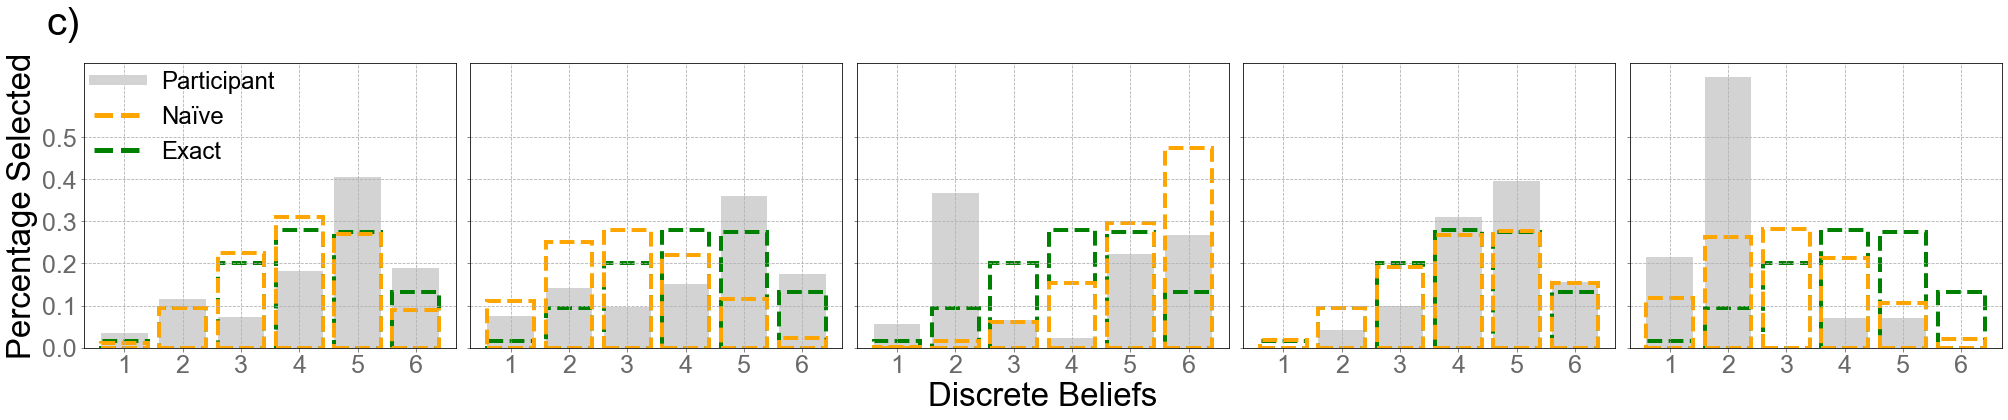

In [355]:
# PLOTTING PLANET SELECTION CONDITIONAL ON STRUCTURE  (NOW ONLY 5 PANELS)
# DISCRETE BETA
import matplotlib.patches as mpatches
def plot_bins(params,subj_params,params_exact,n_bins=6):
    fig, axs = plt.subplots(1, 5, figsize=(28,6),sharey=True,sharex=True) 
#     fig.delaxes(axs[2,1])
    ax_pos = {'indep': [0], 'b->c': [1],'c->b': [2], 'b<->c': [3],'b<->c_echo': [4]} 
    bins = ['1','2','3','4','5','6'] 
    bin_colors = ['deepskyblue','deepskyblue','deepskyblue','red','red','red']
    bin_alphas = np.repeat(1,6)
    fig_labels = {'indep': 'a)', 'b->c': 'b)','c->b': 'c)', 'b<->c': 'd)','b<->c_echo': 'd)'} 
    fig_heading = {'indep': r'$Independent$', 'b->c': r'$B\rightarrow C$','c->b': r'$C\rightarrow B$', 'b<->c': r'$B\leftrightarrow C_{inhibit}$','b<->c_echo': r'$B\leftrightarrow C_{excite}$'}
#     plt.suptitle('Continuous Model Predictions', y=1.03, fontsize=20)

    
    for param in list(subj_params.keys()):
        # CREATING SPECIFIC PLOTS
        bins_n = params[param]
        bins = params_exact
        bins_subj = subj_params[param]
        axs[ax_pos[param][0]].grid(True, ls='--')
        

        # SPECIFIC PLOT COMPONENTS
        
        axs[ax_pos[param][0]].bar(0, bins_subj[0],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(0, bins[0],color=['deepskyblue'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(0, bins_n[0],color=['deepskyblue'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        
        
        axs[ax_pos[param][0]].bar(1, bins_subj[1],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(1, bins[1],color=['deepskyblue'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(1, bins_n[1],color=['deepskyblue'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        axs[ax_pos[param][0]].bar(2, bins_subj[2],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(2, bins[2],color=['deepskyblue'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(2, bins_n[2],color=['deepskyblue'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        axs[ax_pos[param][0]].bar(3, bins_subj[3],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(3, bins[3],color=['red'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(3, bins_n[3],color=['deepskyblue'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        axs[ax_pos[param][0]].bar(4, bins_subj[4],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(4, bins[4],color=['red'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(4, bins_n[4],color=['deepskyblue'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        axs[ax_pos[param][0]].bar(5, bins_subj[5],color=['lightgrey'],alpha=1,linewidth=4)
        axs[ax_pos[param][0]].bar(5, bins[5],color=['red'],edgecolor='green',alpha=1,linewidth=4,linestyle= '--',fill=False)
        axs[ax_pos[param][0]].bar(5, bins_n[5],color=['deepskyblue'],edgecolor='orange',alpha=1,linewidth=4,linestyle= '--',fill=False)
       
        
#         axs[ax_pos[param][0]].title.set_text(fig_heading[param])
        axs[ax_pos[param][0]].set_xticks(np.arange(0,6)) 
        axs[ax_pos[param][0]].set_xticklabels(np.arange(1,7)) 
        axs[ax_pos[param][0]].set_yticks(np.arange(0,max(bins_subj),max(bins_subj)/6))
#         axs[ax_pos[param][0]].set_yticklabels([np.round(i,2) for i in np.arange(0,max(bins_subj),max(bins_subj)/6)])
        axs[ax_pos[param][0]].set_yticks(np.arange(0,0.6,0.1))
#         axs[ax_pos[param][0]].title.set_text(fig_heading[param])
       
        if ax_pos[param][0] == 0: 
            axs[ax_pos[param][0]].set_ylabel('Percentage Selected')
        
#         # CUSTOMISE BINS AND TICKS FOR EACH PLOT
        if ax_pos[param][0] == 0: 
            axs[ax_pos[param][0]].text(-0.1, 1.1,'c)', transform=axs[ax_pos[param][0]].transAxes, 
            size=40)   
#     plt.xlabel('Discrete Beliefs')
        red_patch = mpatches.Patch(color='orange', label='The red data',linestyle='--',edgecolor='green')
#         plt.legend(handles=[red_patch])
        labels = ['Participant','Naïve','Exact','d']
        from matplotlib.lines import Line2D
        custom_lines = [Line2D([0], [0], color='lightgrey', lw=10),
                Line2D([0], [0], color='Orange',linestyle='--',lw=5),
                Line2D([0], [0], color='Green',linestyle='--',lw=5)]
        
        if ax_pos[param][0] == 0:
            axs[ax_pos[param][0]].legend(custom_lines,['Participant', 'Naïve', 'Exact'],loc='upper left', bbox_to_anchor=(-0.03, 1.05), ncol=1,fontsize=24,frameon=False)
        if ax_pos[param][0] == 2: 
            axs[ax_pos[param][0]].set_xlabel('Discrete Beliefs')
#     fig.text(0.52, .065, 'Discrete Beliefs', va='center', ha='center',fontsize=33)
    fig.tight_layout()
    plt.savefig('model_predictions_structure_5.pdf') 
    plt.show()
    

b = [a + b for a,b in zip(param_bins_mod['b<->c'],param_bins_mod['b<->c_echo'])]
print(b)
print(param_bins_mod['b<->c'][0])
print(param_bins_mod['b<->c_echo'][0])
param_bins_mod_combined['b<->c'] = [i/np.sum(b) for i in b]
print(param_bins_mod_combined['b<->c'])
print(param_bins_mod_combined)
plot_bins(param_bins_mod_naive,param_bins_subj_recoded,param_bins_mod_exact['indep'])

In [356]:
print(recoded_subjs_selection)

{'independent': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 'b->c': [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 'c->b': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 'b